# Deep Learning with Artificial Neural Networks
In this notebook we will be working in tensorflow with artificial neural networks to try and see if we can achieve a better accuracy than the models we had in scikit-learn.

In [73]:
# import the basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf

# filter warnings  (some packages produce lots of warnings)
import warnings
warnings.filterwarnings("ignore")

In [74]:
# read in data
df = pd.read_csv('data/clean_data.csv')

In [75]:
# set option to see all columns
pd.set_option('display.max_columns', None)
# check
df.sample(5)

,winner_is_blue,is_title_bout,no_of_rounds,lose_streak_dif,win_streak_dif,win_dif,loss_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,empty_arena,total_fight_time_secs,finish_DQ,finish_KO/TKO,finish_M-DEC,finish_Overturned,finish_S-DEC,finish_SUB,finish_U-DEC,year,month,day,Australia,Brazil,Canada,Chile,China,Croatia,Czech Republic,Denmark,Germany,Ireland,Japan,Mexico,Netherlands,New Zealand,Philippines,Poland,Russia,Singapore,South Korea,Sweden,USA,United Arab Emirates,United Kingdom,Uruguay,Catch Weight,Featherweight,Flyweight,Heavyweight,Light Heavyweight,Lightweight,Middleweight,Welterweight,Women's Bantamweight,Women's Featherweight,Women's Flyweight,Women's Strawweight,B_Southpaw,B_Switch,R_Southpaw,R_Switch,better_rank_Red,weight_dif,ev_dif,draw_dif,avg_SIG_STR_pct_dif,avg_TD_pct_dif,win_by_Decision_Majority_dif,win_by_Decision_Split_dif,win_by_TKO_Doctor_Stoppage_dif
2788,0,0,3,-1,-1,-2,2,-1,-1,0,0.00,-7.62,1,-5.000000,0.800000,-0.200000,0,269.0,0,0,0,0,0,1,0,2014,9,13,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43.076923,0,0.338000,-0.100000,0,-1,0
3656,1,0,3,-1,-1,3,-2,1,-1,5,-2.54,-10.16,-4,-8.846154,0.500000,-1.076923,0,47.0,0,1,0,0,0,0,0,2012,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,63.069930,0,-0.054038,-0.288558,0,-1,0
2104,0,0,3,0,0,0,0,0,-1,0,-12.70,-7.62,-1,-10.000000,-0.333333,1.000000,0,285.0,0,1,0,0,0,0,0,2016,2,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,272.222222,0,-0.436667,0.083333,0,1,0
3415,1,0,3,0,0,-1,0,0,-1,0,0.00,10.16,-2,-18.000000,0.000000,-0.500000,0,900.0,0,0,0,0,0,0,1,2013,4,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-128.717949,0,-0.145000,-0.500000,0,0,0
1851,1,0,3,0,0,-1,0,0,-1,0,-5.08,-2.54,3,51.500000,0.000000,2.000000,0,859.0,0,1,0,0,0,0,0,2016,9,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-353.723404,0,-0.095000,0.250000,0,0,0


We will again use imbalance learn's random oversampling method to correct the imbalance in our dependent variable before getting into modelling.

In [76]:
# define our X and y
X = df.drop(['winner_is_blue'], axis = 1)
y = df['winner_is_blue']

In [77]:
# import random over sampler
from imblearn.over_sampling import RandomOverSampler

In [78]:
# instantiate
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# check new balance
y_over.value_counts()

1    2541
0    2541
Name: winner_is_blue, dtype: int64

In [79]:
# create a new dataset from oversampling
df = pd.concat([X_over, y_over], axis=1)

#### Dropping the year column:
After trying different methods to split our data, the train_test_split method in sklearn gave me the best results. Ergo, I will drop the year column to basically avoid predicting 'past' results from 'future' matches. The year should not have any major predictive role anyways. Another method of splitting that I tried was to make 2019 and 2020 my test, 2018 my validation and the rest my train data. However, the results are more conistent here.

In [80]:
# drop year
df.drop(['year'], axis=1, inplace = True)

#### Perform train_test_split and scale:
As mentioned, we will use sklearns method of randomly creating train test split tests. We will then scale the data. Neural networks are heavily reliant on scaling since the different weights from the inputs will be very different if not scaled and that can skew a models' predictions. Here the standard scaler proved to be the best.

In [118]:
# define our X and y
X = df.drop(['winner_is_blue', 'total_fight_time_secs', 'finish_DQ', 'finish_KO/TKO', 'finish_M-DEC', 'finish_Overturned',
             'finish_S-DEC', 'finish_SUB', 'finish_U-DEC'], axis = 1)
y = df['winner_is_blue']

# create test and remainder sets
X_remainder, X_test, y_remainder, y_test = \
    train_test_split(X, y, test_size = 0.15,
                     random_state=1)

# Splitting the remainder in two chunks
X_train, X_val, y_train, y_val = \
    train_test_split(X_remainder, y_remainder, test_size = 0.15,
                     random_state=1)

In [119]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [107]:
#check
X_train

array([[-0.22839427, -0.31745068, -0.17410208, ...,  0.06959347,
         0.13795323,  0.06657221],
       [-0.22839427, -0.31745068, -0.17410208, ...,  0.06959347,
         0.13795323,  0.06657221],
       [-0.22839427, -0.31745068,  0.87022593, ...,  0.06959347,
        -2.30855061,  0.06657221],
       ...,
       [-0.22839427, -0.31745068, -2.26275811, ...,  0.06959347,
         0.13795323,  0.06657221],
       [-0.22839427, -0.31745068, -1.2184301 , ...,  0.06959347,
         0.13795323,  0.06657221],
       [-0.22839427, -0.31745068,  0.87022593, ...,  0.06959347,
         0.13795323,  0.06657221]])

### Running the models:
Lets start by creating many layers with 'relu' as their activation function and 'sigmoid' as the output's activation function since we have a binary. Other activation functions were also tested, however relu and sigmoid seemed to be our best ones.

In [108]:
# initialize
ann = tf.keras.models.Sequential()
# add input layer and hidden layer
ann.add(tf.keras.layers.Dense(100, activation = 'relu'))
ann.add(tf.keras.layers.Dense(100, activation = 'relu'))
ann.add(tf.keras.layers.Dense(100, activation = 'relu'))
ann.add(tf.keras.layers.Dense(100, activation = 'relu'))
ann.add(tf.keras.layers.Dense(100, activation = 'relu'))
ann.add(tf.keras.layers.Dense(100, activation = 'relu'))
ann.add(tf.keras.layers.Dense(100, activation = 'relu'))
ann.add(tf.keras.layers.Dense(100, activation = 'relu'))
ann.add(tf.keras.layers.Dense(100, activation = 'relu'))
ann.add(tf.keras.layers.Dense(100, activation = 'relu'))
# add output layer
ann.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# Compile the model
ann.compile(
    optimizer= 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Train the model
ann.fit(X_train, 
        y_train, 
        batch_size = 32,
        epochs=100, 
        verbose=1, 
        # Pass in a validation data set to test each epoch.
        validation_data=(X_val, y_val))

Epoch 1/100
115/115 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.5876 - val_loss: 0.6613 - val_accuracy: 0.5972
Epoch 2/100
115/115 [==============================] - 0s 2ms/step - loss: 0.6262 - accuracy: 0.6540 - val_loss: 0.6454 - val_accuracy: 0.6265
Epoch 3/100
115/115 [==============================] - 0s 2ms/step - loss: 0.5911 - accuracy: 0.6835 - val_loss: 0.6496 - val_accuracy: 0.5818
Epoch 4/100
115/115 [==============================] - 0s 2ms/step - loss: 0.5713 - accuracy: 0.7093 - val_loss: 0.6509 - val_accuracy: 0.6327
Epoch 5/100
115/115 [==============================] - 0s 2ms/step - loss: 0.5139 - accuracy: 0.7461 - val_loss: 0.6892 - val_accuracy: 0.6373
Epoch 6/100
115/115 [==============================] - 0s 2ms/step - loss: 0.4724 - accuracy: 0.7804 - val_loss: 0.7742 - val_accuracy: 0.6404
Epoch 7/100
115/115 [==============================] - 0s 3ms/step - loss: 0.4168 - accuracy: 0.8112 - val_loss: 0.8294 - val_accuracy: 0.6574

Epoch 58/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.9905 - val_loss: 2.1981 - val_accuracy: 0.6682
Epoch 59/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0356 - accuracy: 0.9907 - val_loss: 2.7058 - val_accuracy: 0.6512
Epoch 60/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9891 - val_loss: 2.4019 - val_accuracy: 0.6759
Epoch 61/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0365 - accuracy: 0.9913 - val_loss: 2.7428 - val_accuracy: 0.6898
Epoch 62/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9951 - val_loss: 3.2906 - val_accuracy: 0.6836
Epoch 63/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0269 - accuracy: 0.9913 - val_loss: 1.8488 - val_accuracy: 0.6698
Epoch 64/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9910 - val_loss: 2.4117 - val_accuracy:

Lets now add kernel regularizers to see if they can improve our model.

In [109]:
# initialize
ann = tf.keras.models.Sequential()

# Create a regularizer with a factor of 0.005 and apply it to all hidden layers
regularizer = tf.keras.regularizers.l2(0.005)

# add input layer and hidden layer
ann.add(tf.keras.layers.Dense(100, activation = 'relu', kernel_regularizer=regularizer))
ann.add(tf.keras.layers.Dense(100, activation = 'relu', kernel_regularizer=regularizer))
ann.add(tf.keras.layers.Dense(100, activation = 'relu', kernel_regularizer=regularizer))
ann.add(tf.keras.layers.Dense(100, activation = 'relu', kernel_regularizer=regularizer))
ann.add(tf.keras.layers.Dense(100, activation = 'relu', kernel_regularizer=regularizer))
ann.add(tf.keras.layers.Dense(100, activation = 'relu', kernel_regularizer=regularizer))
ann.add(tf.keras.layers.Dense(100, activation = 'relu', kernel_regularizer=regularizer))
ann.add(tf.keras.layers.Dense(100, activation = 'relu', kernel_regularizer=regularizer))
ann.add(tf.keras.layers.Dense(100, activation = 'relu', kernel_regularizer=regularizer))
ann.add(tf.keras.layers.Dense(100, activation = 'relu', kernel_regularizer=regularizer))
# add output layer
ann.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# Compile the model
ann.compile(
    optimizer= 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Train the model
ann.fit(X_train, 
        y_train, 
        batch_size = 32,
        epochs=100, 
        verbose=1, 
        # Pass in a validation data set to test each epoch.
        validation_data=(X_val, y_val))

Epoch 1/100
115/115 [==============================] - 1s 4ms/step - loss: 2.7240 - accuracy: 0.4996 - val_loss: 1.1793 - val_accuracy: 0.5031
Epoch 2/100
115/115 [==============================] - 0s 2ms/step - loss: 0.8602 - accuracy: 0.4911 - val_loss: 0.7188 - val_accuracy: 0.5031
Epoch 3/100
115/115 [==============================] - 0s 2ms/step - loss: 0.7005 - accuracy: 0.4917 - val_loss: 0.6938 - val_accuracy: 0.5031
Epoch 4/100
115/115 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5031
Epoch 5/100
115/115 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4884 - val_loss: 0.6931 - val_accuracy: 0.5031
Epoch 6/100
115/115 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5031
Epoch 7/100
115/115 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6932 - val_accuracy: 0.4969

Epoch 58/100
115/115 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5031
Epoch 59/100
115/115 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4816 - val_loss: 0.6931 - val_accuracy: 0.4969
Epoch 60/100
115/115 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4952 - val_loss: 0.6932 - val_accuracy: 0.4969
Epoch 61/100
115/115 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6932 - val_accuracy: 0.4969
Epoch 62/100
115/115 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.5031
Epoch 63/100
115/115 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4892 - val_loss: 0.6931 - val_accuracy: 0.4969
Epoch 64/100
115/115 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6931 - val_accuracy:

The model got much worse with the regularizers. Lets now to add more nodes to see how that changes things.

In [17]:
# initialize
ann = tf.keras.models.Sequential()
# add input layer and hidden layer
ann.add(tf.keras.layers.Dense(150, activation = 'relu'))
ann.add(tf.keras.layers.Dense(150, activation = 'relu'))
ann.add(tf.keras.layers.Dense(150, activation = 'relu'))
ann.add(tf.keras.layers.Dense(150, activation = 'relu'))
ann.add(tf.keras.layers.Dense(150, activation = 'relu'))
ann.add(tf.keras.layers.Dense(150, activation = 'relu'))
ann.add(tf.keras.layers.Dense(150, activation = 'relu'))
ann.add(tf.keras.layers.Dense(150, activation = 'relu'))
ann.add(tf.keras.layers.Dense(150, activation = 'relu'))
ann.add(tf.keras.layers.Dense(150, activation = 'relu'))
ann.add(tf.keras.layers.Dense(150, activation = 'relu'))
ann.add(tf.keras.layers.Dense(150, activation = 'relu'))
# add output layer
ann.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# Compile the model
ann.compile(
    optimizer= 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Train the model
ann.fit(X_train, 
        y_train, 
        batch_size = 32,
        epochs=100, 
        verbose=1, 
        # Pass in a validation data set to test each epoch.
        validation_data=(X_val, y_val))

Epoch 1/100
115/115 [==============================] - 1s 5ms/step - loss: 0.6824 - accuracy: 0.5484 - val_loss: 0.6785 - val_accuracy: 0.6420
Epoch 2/100
115/115 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6440 - val_loss: 0.6251 - val_accuracy: 0.6620
Epoch 3/100
115/115 [==============================] - 0s 3ms/step - loss: 0.6068 - accuracy: 0.6728 - val_loss: 0.6179 - val_accuracy: 0.6620
Epoch 4/100
115/115 [==============================] - 0s 3ms/step - loss: 0.5620 - accuracy: 0.7099 - val_loss: 0.6629 - val_accuracy: 0.6127
Epoch 5/100
115/115 [==============================] - 0s 4ms/step - loss: 0.5261 - accuracy: 0.7344 - val_loss: 0.6779 - val_accuracy: 0.6559
Epoch 6/100
115/115 [==============================] - 0s 3ms/step - loss: 0.4713 - accuracy: 0.7736 - val_loss: 0.6827 - val_accuracy: 0.6713
Epoch 7/100
115/115 [==============================] - 0s 3ms/step - loss: 0.4068 - accuracy: 0.8041 - val_loss: 0.8499 - val_accuracy: 0.6451

Epoch 58/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0637 - accuracy: 0.9834 - val_loss: 1.9742 - val_accuracy: 0.6975
Epoch 59/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0250 - accuracy: 0.9913 - val_loss: 2.2389 - val_accuracy: 0.6867
Epoch 60/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0470 - accuracy: 0.9877 - val_loss: 2.2287 - val_accuracy: 0.6898
Epoch 61/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0274 - accuracy: 0.9916 - val_loss: 1.9187 - val_accuracy: 0.6836
Epoch 62/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0153 - accuracy: 0.9940 - val_loss: 3.0234 - val_accuracy: 0.6991
Epoch 63/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0163 - accuracy: 0.9956 - val_loss: 2.1349 - val_accuracy: 0.6867
Epoch 64/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0374 - accuracy: 0.9894 - val_loss: 2.3043 - val_accuracy:

That did not help either. Perhaps we are using too many layers and we don't need that many since our dataset size is relatively small. We should also add dropout layers to prevent the model overfitting quickly. Note that many dropout rates starting from 0.2 up to 0.8 were tested and 0.7 seemed to be the sweet spot.

In [139]:
# initialize
ann = tf.keras.models.Sequential()
# add input layer and hidden layer
ann.add(tf.keras.layers.Dense(100, activation = 'relu'))
ann.add(tf.keras.layers.Dropout(0.7)) # Set 20% of the nodes to 0
ann.add(tf.keras.layers.Dense(100, activation = 'relu'))
ann.add(tf.keras.layers.Dropout(0.7))
ann.add(tf.keras.layers.Dense(100, activation = 'relu'))
ann.add(tf.keras.layers.Dropout(0.8))

# add output layer
ann.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# Compile the model
ann.compile(
    optimizer= 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Train the model
history = ann.fit(X_train, 
        y_train, 
        batch_size = 32,
        epochs=50, 
        verbose=1, 
        # Pass in a validation data set to test each epoch.
        validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 0s 3ms/step - loss: 1.0357 - accuracy: 0.5116 - val_loss: 0.6868 - val_accuracy: 0.5093
Epoch 2/50
115/115 [==============================] - 0s 2ms/step - loss: 0.8279 - accuracy: 0.5176 - val_loss: 0.6872 - val_accuracy: 0.5617
Epoch 3/50
115/115 [==============================] - 0s 2ms/step - loss: 0.7662 - accuracy: 0.5072 - val_loss: 0.6895 - val_accuracy: 0.5494
Epoch 4/50
115/115 [==============================] - 0s 2ms/step - loss: 0.7429 - accuracy: 0.5064 - val_loss: 0.6908 - val_accuracy: 0.5231
Epoch 5/50
115/115 [==============================] - 0s 2ms/step - loss: 0.7141 - accuracy: 0.5124 - val_loss: 0.6907 - val_accuracy: 0.5694
Epoch 6/50
115/115 [==============================] - 0s 2ms/step - loss: 0.7126 - accuracy: 0.5026 - val_loss: 0.6912 - val_accuracy: 0.6142
Epoch 7/50
115/115 [==============================] - 0s 2ms/step - loss: 0.7002 - accuracy: 0.5217 - val_loss: 0.6904 - val_accuracy: 0.6173
Epoch 

In [140]:
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = ann.evaluate(X_test,y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train Accuracy: 0.6846
Test Accuracy: 0.6121


Unfortunately, even though this final model did not overfit, we got a 61% accuracy at the end which could just be bad luck due to the small test size. However, the SVC model gave me more consistent results at higher accuracies so I will chose that as my final model.

Lets now plot the model loss and accuracy scores over the training period.

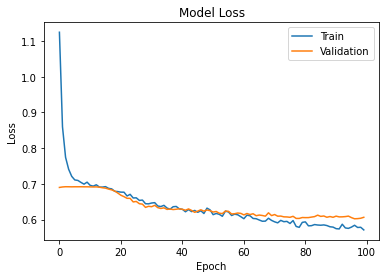

In [136]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.savefig('ann.png')
plt.show()

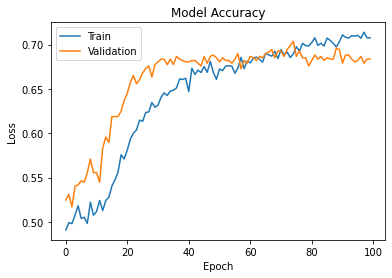

In [138]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.savefig('annac.png')
plt.show()

We can see that the model is no longer overfitting and the train and validation accuracies are close to each other which is a good sign that we have picked out our hyperparameters wisely.